In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pyhessian import hessian

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'mps'

In [4]:
data = pd.read_csv('~/data/MNIST/mnist_train.csv')
test = pd.read_csv('~/data/MNIST/mnist_test.csv')

data = data[data['label'].isin([0, 1])]
test = test[test['label'].isin([0, 1])]

X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255

Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
Y = torch.eye(1, device=device)[Y_temp]

Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
Y_test = torch.eye(1, device=device)[Y_temp]

In [5]:
gen = torch.Generator(device=device)
gen.manual_seed(123)

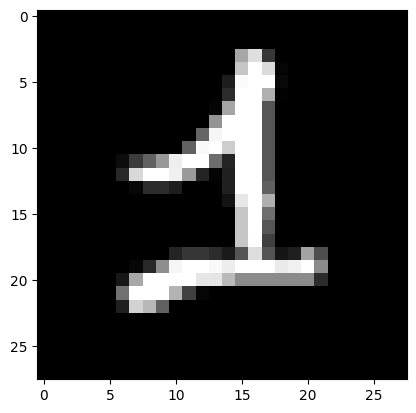

In [6]:
plt.imshow(X[7].view(28,28).cpu(), cmap='gray')

In [7]:
def permut(x, perm = np.random.permutation(X.shape[1])):
    x = x[perm]
    return x

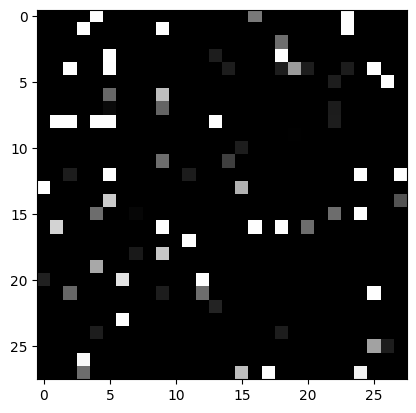

In [8]:
plt.imshow(permut(X[4]).view(28,28).cpu(), cmap='gray')

In [9]:
X_perm = torch.tensor(np.apply_along_axis(permut, axis = 1, arr=X.cpu())).to(device)
X_test_perm = torch.tensor(np.apply_along_axis(permut, axis = 1, arr=X_test.cpu())).to(device)

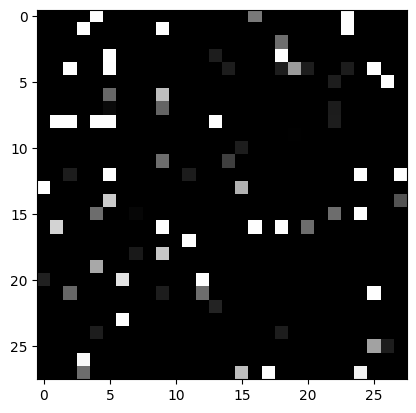

In [10]:
plt.imshow(X_perm[4].cpu().view(28,28), cmap='gray')

In [11]:
from torchsummary import summary

class MLP(nn.Module):
    """Standard MLP"""
    def __init__(self, w, L):
        super(MLP, self).__init__()
        self.w = w
        self.fc1 = nn.Linear(784, self.w)
        self.layers = nn.ModuleList(nn.Linear(self.w,self.w) for _ in range(L))
        self.fc2 = nn.Linear(self.w, 1)
        self.relu = nn.ReLU()
        self.L = L

    def forward(self, x):
        x = self.fc1(x)
        for l in self.layers:
            x = l(x)
        x = self.fc2(x)
        #x = x/np.sqrt(self.w*784)

        return x
    
mlp = MLP(128, 0)
summary(mlp, (1,784))
mlp = mlp.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
            Linear-2                 [-1, 1, 1]             129
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [12]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=2/64)

In [13]:
def top_eigen(model, loss, X, Y, prt=False):

    hess_comp = hessian(model, loss, (X,Y) )
    top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
        
    return top_eigenvalues[-1] , top_eigenvector

In [14]:
MSE = nn.MSELoss()

s, _ = top_eigen(mlp, MSE , X, Y)
print(s)

/opt/homebrew/lib/python3.11/site-packages/torch/autograd/graph.py:690: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1183.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


32.01459503173828


In [15]:
def GSalign(model, eigen):
   z = 0
   for g,p in zip(model.parameters(), eigen[0]):
        if g.requires_grad:
          gd = g.grad
          z += torch.sum(gd*p)/(torch.sqrt(torch.sum(gd*gd))*torch.sqrt(torch.sum(p*p))*len(eigen[0]))

   return z.item()

def little_ev(model):
   
   E = dict(model.named_parameters())['fc1.weight']
   V = dict(model.named_parameters())['fc2.weight']

   e = (E.T @ E)/(E.shape[0]*E.shape[1])
   v = torch.sum((V @ V.T)/(E.shape[0]*E.shape[1]))

   return e, v


In [16]:
loss_hist = []
lam = []
all = []
batch = len(X)

for epoch in range(350):

        running_loss = 0.0
        for i in range(len(X)//batch):

            # Batch of training 
            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

            ixc = torch.randint(0, len(X), (2048,), generator=gen, device=device)
            sharp, eigen = top_eigen(mlp, MSE, X[ixc], Y[ixc])

            optimizer.zero_grad()

            out = mlp(X[ix])
            loss = MSE(out, Y[ix])
            loss.backward()
            running_loss += loss.item()

            all.append(GSalign(mlp,eigen))

            optimizer.step()

            lam.append(sharp)
            loss_hist.append(loss.item())

            print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f} -----> sharpness = {sharp:.3f}')

            if epoch == 349:
                  sharp, eigen = top_eigen(mlp, MSE, X[ixc], Y[ixc])
                  task1_eigen = eigen
                  

print('Finished Training')

acc = []
acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )

(epoch: 0), sample: 12665, ---> train loss = 0.3831 -----> sharpness = 31.283
(epoch: 1), sample: 12665, ---> train loss = 0.0828 -----> sharpness = 32.504
(epoch: 2), sample: 12665, ---> train loss = 0.0573 -----> sharpness = 33.119
(epoch: 3), sample: 12665, ---> train loss = 0.0442 -----> sharpness = 33.673
(epoch: 4), sample: 12665, ---> train loss = 0.0373 -----> sharpness = 33.481
(epoch: 5), sample: 12665, ---> train loss = 0.0333 -----> sharpness = 33.169
(epoch: 6), sample: 12665, ---> train loss = 0.0317 -----> sharpness = 34.488
(epoch: 7), sample: 12665, ---> train loss = 0.0297 -----> sharpness = 33.869
(epoch: 8), sample: 12665, ---> train loss = 0.0291 -----> sharpness = 34.005
(epoch: 9), sample: 12665, ---> train loss = 0.0279 -----> sharpness = 33.854
(epoch: 10), sample: 12665, ---> train loss = 0.0285 -----> sharpness = 35.103
(epoch: 11), sample: 12665, ---> train loss = 0.0277 -----> sharpness = 33.528
(epoch: 12), sample: 12665, ---> train loss = 0.0271 -----> sh

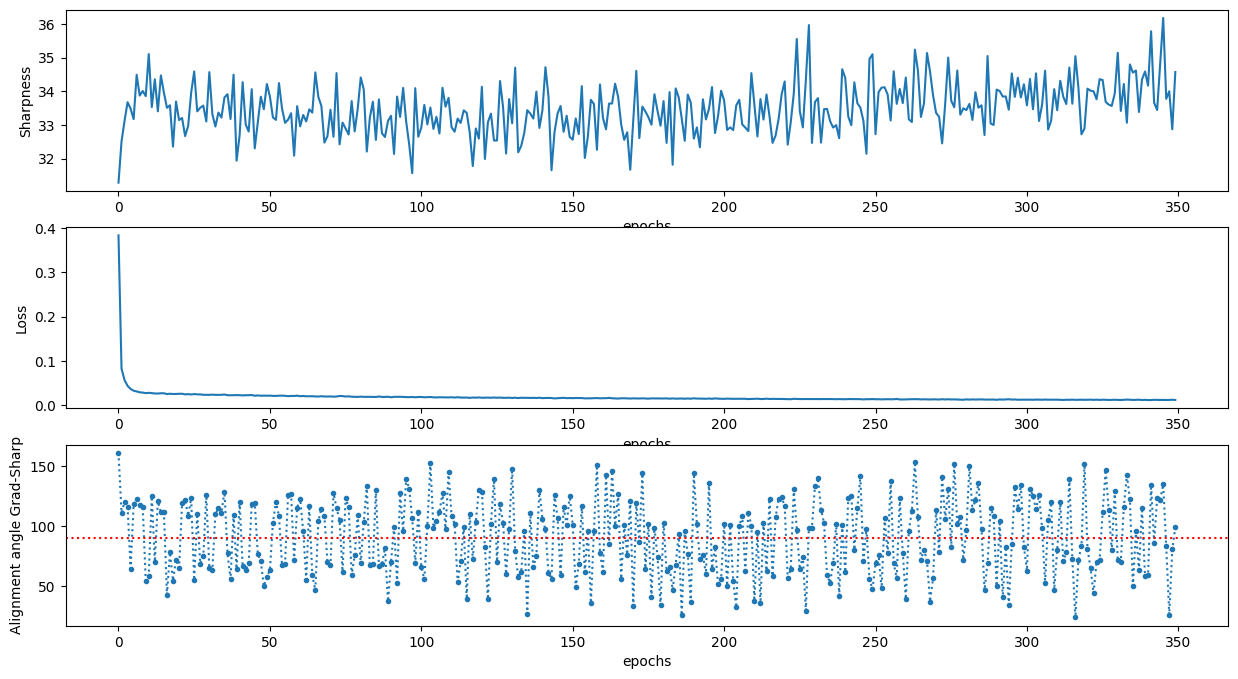

In [17]:
fig, ax = plt.subplots(3,1, figsize=(15,8))

ax[0].plot(lam)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Sharpness')

ax[1].plot(loss_hist)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Loss')

ax[2].plot(np.arccos(all)*180/np.pi, linestyle=':', marker='.')
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Alignment angle Grad-Sharp')
ax[2].axhline(90, color='r', linestyle='dotted')
plt.show()

In [18]:
acc = []
acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )

In [19]:
acc

[tensor(1., device='mps:0')]

In [20]:
hess_comp = hessian( mlp, MSE, (X,Y) )
top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()

print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[0])

The top Hessian eigenvalue of this model is 34.1625


In [21]:
hess_comp = hessian(mlp, MSE, (X_perm,Y) )
top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is", top_eigenvalues[0])

The top Hessian eigenvalue of this model is 34.74982833862305


In [22]:
lr = 2/64
optimizer = torch.optim.SGD(mlp.parameters(), lr=lr)

old_loss = [0]
batch = 1
forg = []

In [23]:
def forget(model,X1,Y1,X2,Y2,gam,lr, loss1, loss2):

    delta1 = loss1
    #print(delta1)
    delta2 = loss2
    #print(delta2)
    e, v = little_ev(model)

    term1 = ( X1 @ (e @ X2.T) + (X1 @ X2.T) * v) * delta2 * lr
    #print(term1)

    term2 = (X1 @ X2.T) @ model(X2) * delta2**2 * lr**2
    #print(term2)

    f = torch.sum((delta1 - (128*784*term1 - term2))**2)
    #print(f)

    return f.item()

In [24]:
for epoch in range(1):

        running_loss = 0.0
        for i in range(1000):

            # Batch of training 
            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

            ixc = torch.randint(0, len(X), (2048,), generator=gen, device=device)
            sharp, eigen = top_eigen(mlp, MSE, X[ixc], Y[ixc])

            optimizer.zero_grad()
 
            out = mlp(X_perm[ix])
            loss = MSE(out, Y[ix])
            loss.backward()
            running_loss += loss.item()

            all.append(GSalign(mlp,eigen))

            forg.append(forget(mlp, X[ix], Y[ix], X_perm[ix], Y[ix], 0, lr, np.sqrt(old_loss[-1]), np.sqrt(loss_hist[-1]) ))

            optimizer.step()

            lam.append(sharp)
            loss_hist.append(loss.item())
            old_loss.append( MSE( mlp(X[ix]) , Y[ix]).item() )

            print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f} -----> sharpness = {sharp:.3f}')

print('Finished Training')

acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )

(epoch: 0), sample: 1, ---> train loss = 0.1449 -----> sharpness = 35.420
(epoch: 0), sample: 2, ---> train loss = 0.0061 -----> sharpness = 33.565
(epoch: 0), sample: 3, ---> train loss = 0.0376 -----> sharpness = 33.568
(epoch: 0), sample: 4, ---> train loss = 0.0000 -----> sharpness = 33.693
(epoch: 0), sample: 5, ---> train loss = 0.3182 -----> sharpness = 33.835
(epoch: 0), sample: 6, ---> train loss = 0.0460 -----> sharpness = 37.273
(epoch: 0), sample: 7, ---> train loss = 0.0000 -----> sharpness = 36.699
(epoch: 0), sample: 8, ---> train loss = 0.0082 -----> sharpness = 38.316
(epoch: 0), sample: 9, ---> train loss = 0.0055 -----> sharpness = 36.750
(epoch: 0), sample: 10, ---> train loss = 0.0001 -----> sharpness = 37.604
(epoch: 0), sample: 11, ---> train loss = 0.0535 -----> sharpness = 37.461
(epoch: 0), sample: 12, ---> train loss = 0.2037 -----> sharpness = 37.138
(epoch: 0), sample: 13, ---> train loss = 0.0871 -----> sharpness = 34.945
(epoch: 0), sample: 14, ---> train

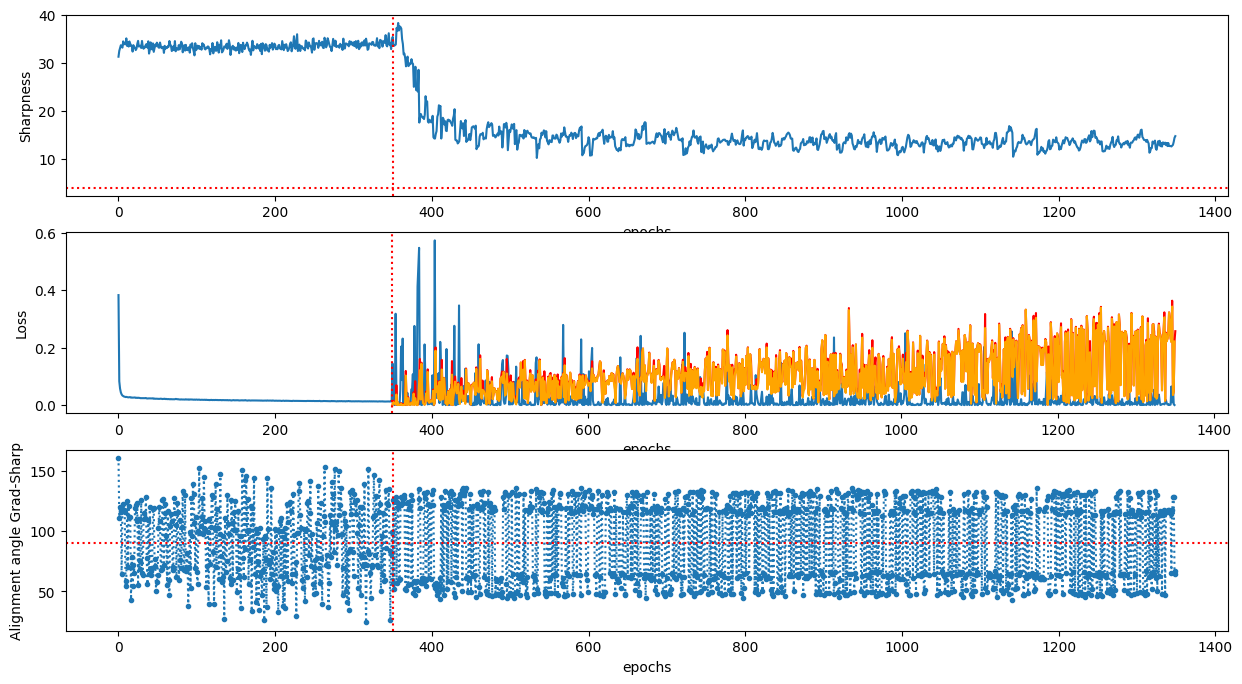

In [25]:
fig, ax = plt.subplots(3,1, figsize=(15,8))

ax[0].plot(lam)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Sharpness')
ax[0].axvline(350, color='r', linestyle='dotted')
ax[0].axhline(4, color='r', linestyle='dotted')


ax[1].plot(loss_hist)
ax[1].plot(np.arange(350,350+1001),old_loss, color='red')
ax[1].plot(np.arange(350,350+1000),forg, color='orange')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Loss')
ax[1].axvline(350, color='r', linestyle='dotted')

ax[2].plot(np.arccos(all)*180/np.pi, linestyle=':', marker='.')
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Alignment angle Grad-Sharp')
ax[2].axvline(350, color='r', linestyle='dotted')
ax[2].axhline(90, color='r', linestyle='dotted')
plt.show()


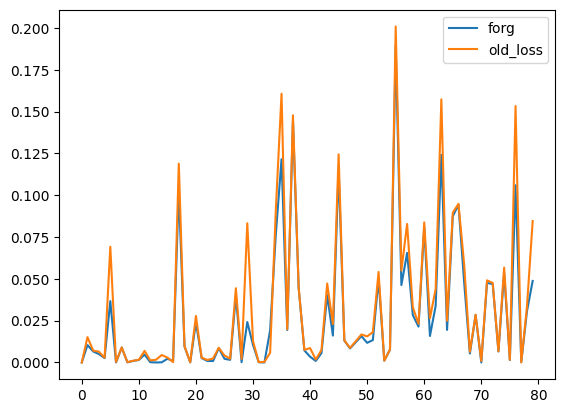

In [34]:
plt.plot(forg[:80], label='forg')
plt.plot(old_loss[:80], label='old_loss')
plt.legend()

In [27]:
forg

[2.248431155749131e-05,
 0.010393179953098297,
 0.006574904080480337,
 0.005060847848653793,
 0.0026252474635839462,
 0.036698874086141586,
 1.2426140756360837e-06,
 0.00894746370613575,
 7.835811993572861e-05,
 0.0009288837900385261,
 0.0015058054123073816,
 0.004727398045361042,
 0.00016478357429150492,
 4.69867154606618e-06,
 8.978663390735164e-05,
 0.002211826154962182,
 0.0009376060916110873,
 0.10280458629131317,
 0.009533450938761234,
 4.720837387139909e-05,
 0.024036819115281105,
 0.002641109051182866,
 0.0008831720915623009,
 0.0008600947912782431,
 0.00859549455344677,
 0.0021997157018631697,
 0.0015853416407480836,
 0.03980342671275139,
 0.00018594303401187062,
 0.02418694645166397,
 0.010526602156460285,
 0.00016740754654165357,
 2.600376319605857e-06,
 0.019213223829865456,
 0.07671696692705154,
 0.12153124064207077,
 0.0194478128105402,
 0.14417335391044617,
 0.04461343586444855,
 0.007200244814157486,
 0.0034537615720182657,
 0.0009167324751615524,
 0.005632010754197836,

In [28]:
torch.sum(torch.argmax(mlp(X_test_perm), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)

tensor(1., device='mps:0')

In [29]:
acc

[tensor(1., device='mps:0'), tensor(1., device='mps:0')]

In [30]:
counts, bins = torch.histogram(torch.tensor(all[:350]), 50)
counts1, bins1 = torch.histogram(torch.tensor(all[350:]), 50)

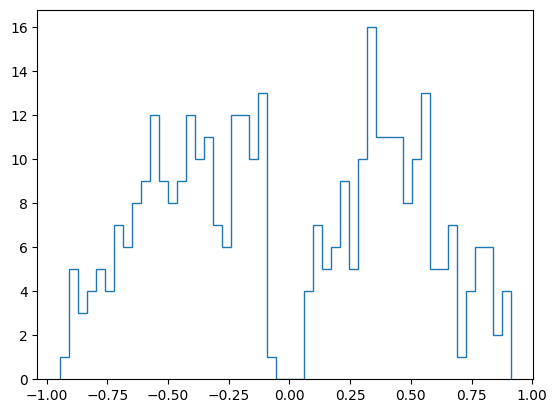

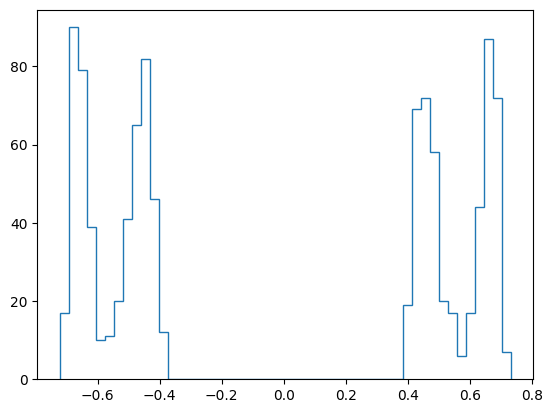

In [31]:
plt.stairs(counts, bins)
plt.show()
plt.stairs(counts1, bins1)
plt.show()